In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
# !pip install -q tensorflow==2.16.1 tensorflow-text==2.16.1

In [ ]:
import kagglehub
path = kagglehub.dataset_download("adityajn105/flickr8k")
path

Using Colab cache for faster access to the 'flickr8k' dataset.


'/kaggle/input/flickr8k'

In [ ]:
CAPTIONS_FILE = os.path.join(path, "captions.txt")

In [ ]:
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense,Embedding , Dropout
from tensorflow.keras.layers import LSTM,LeakyReLU,GRU,Add,BatchNormalization,SimpleRNN,GlobalAveragePooling2D,Bidirectional,Conv2D , MaxPooling2D,Flatten,Input,TextVectorization,Normalization,Rescaling
from tensorflow.keras.datasets import imdb
from tensorflow.keras.metrics import F1Score,AUC
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from glob import glob
import os
import csv
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt

In [ ]:
print(tf.__version__)

2.19.0


In [ ]:
# import tensorflow as tf

# try:
#     # Use 'local' for TPU v5e (TPU VM)
#     tpu = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='local')
#     print('Device:', tpu.master())

#     tf.config.experimental_connect_to_cluster(tpu)
#     tf.tpu.experimental.initialize_tpu_system(tpu)

#     strategy = tf.distribute.TPUStrategy(tpu)
#     print('Number of replicas:', strategy.num_replicas_in_sync)

# except ValueError:
#     print("TPU not found. Defaulting to CPU/GPU.")
#     strategy = tf.distribute.get_strategy()


In [ ]:

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    print("GPU detected:", gpus)
else:
    print("No GPU detected")

print("\nDetailed devices:")
print(tf.config.list_physical_devices())

GPU detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Detailed devices:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
os.listdir()

['.config', 'sample_data']

In [ ]:
# file_text=''
# with open(path+'/captions.txt','r') as file:
#   lines = file.readlines()
# with open('./caption.csv','w', newline='') as file_csv:
#      writering=csv.writer(file_csv)
#      for line in lines:
#         parts = line.strip().split(',', 1)
#         writering.writerow(parts)

In [ ]:
def load_captions(captions_file):
    captions_dict = {}

    with open(captions_file, 'r') as f:
        for line in f:
            if ',' not in line:
                continue

            image_id, caption = line.split(',', 1)
            caption = caption.lower().strip()
            caption = caption.replace('.', '').replace(',', '')
            caption = "<start> " + caption + " <end>"

            captions_dict.setdefault(image_id, []).append(caption)

    return captions_dict


captions_dict = load_captions(CAPTIONS_FILE)


In [ ]:
def create_tokenizer(descriptions):
    token=Tokenizer(num_words=50000,oov_token="<unk>")
    lines=[]
    for key in descriptions.keys():
        [lines.append(d) for d in descriptions[key]]
    token.fit_on_texts(lines)
    return token

In [ ]:
tokenizer = create_tokenizer(captions_dict)
len(tokenizer.word_index)

8491

In [ ]:
#  max_len=40
# def  caption_to_pad(capt):
#     seq=token.texts_to_sequences([capt])[0]
#     return sequence.pad_sequences([seq],maxlen=max_len)




In [ ]:
def creating_traing_data(descriptions, photos, tokenizer, max_length, batch_size):
    X1, X2, y = list(), list(), list()
    n = 0
    while True:
        for key, desc_list in descriptions.items():
            if key not in photos:
                continue
            n += 1
            photo = photos[key]

            for desc in desc_list:
                seq = tokenizer.texts_to_sequences([desc])[0]
                for i in range(1, len(seq)):
                    in_seq = seq[:i]
                    out_word = seq[i]
                    in_seq = sequence.pad_sequences([in_seq], maxlen=max_length,padding='post')[0]

                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_word)


            if n == batch_size:

                yield ((np.array(X1), np.array(X2)), np.array(y))
                X1, X2, y = list(), list(), list()
                n = 0




In [ ]:
from tensorflow.keras.applications.vgg16 import preprocess_input

def load_and_preprocess(image_path):
    img = cv.imread(image_path)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    img = cv.resize(img, (224,224))
    img = preprocess_input(img)
    return img


In [ ]:
load_and_preprocess(path + '/Images/' + '1000268201_693b08cb0e.jpg').shape

(224, 224, 3)

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16

def build_feature_model():
    base_model = VGG16(weights='imagenet', include_top=True)
    base_model.trainable = False
    feature_model = Model(
        inputs=base_model.input,
        outputs=base_model.get_layer('fc2').output
    )
    return feature_model


In [ ]:
model_cnn=build_feature_model()

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 24s 0us/step


In [ ]:
model_cnn.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 134,260,544 (512.16 MB)

In [ ]:
def extract_all_features(dictionary, model):
    features = {}
    for img_id in dictionary.keys():
        if 'image' in img_id:
            continue
        img_path = os.path.join(path, 'Images', img_id)
        image = load_and_preprocess(img_path)

        feature_vectors = model.predict(np.expand_dims(image, 0), verbose=0)[0]
        features[img_id] = feature_vectors
    return features

vector_f = extract_all_features(captions_dict, model_cnn)


In [ ]:
print('hello')

hello


In [ ]:
len(vector_f['1000268201_693b08cb0e.jpg'])

4096

In [ ]:
vector_f

{'1000268201_693b08cb0e.jpg': array([1.7018996, 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ], dtype=float32),
 '1001773457_577c3a7d70.jpg': array([0.        , 0.        , 0.38058862, ..., 0.        , 0.        ,
        0.        ], dtype=float32),
 '1002674143_1b742ab4b8.jpg': array([1.5245209 , 0.        , 0.46584392, ..., 2.528692  , 2.544994  ,
        0.        ], dtype=float32),
 '1003163366_44323f5815.jpg': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 '1007129816_e794419615.jpg': array([0.       , 0.4391848, 0.       , ..., 0.       , 0.       ,
        0.       ], dtype=float32),
 '1007320043_627395c3d8.jpg': array([0.       , 0.       , 0.       , ..., 0.       , 3.8408194,
        0.       ], dtype=float32),
 '1009434119_febe49276a.jpg': array([1.4700387 , 2.196397  , 3.3567934 , ..., 0.56241065, 1.3196628 ,
        0.        ], dtype=float32),
 '1012212859_01547e3f17.jpg': array([0.        , 0.        , 1.2143309 , ..., 0.        , 0.9210922 ,

In [ ]:
def perplexity(y_true, y_pred):
    loss = tf.keras.losses.sparse_categorical_crossentropy(
        y_true, y_pred
    )
    return tf.exp(tf.reduce_mean(loss))

def defintion_model(vocab_s,max_lenght):
    input_1=Input(shape=(4096,))
    fe1 = Dropout(0.5)(input_1)
    fe2 = Dense(512, activation='relu')(fe1)

    inputs2=Input(shape=(max_lenght,))
    x = Embedding(vocab_s,256, mask_zero=True)(inputs2)
    x=Dropout(0.5)(x)
    x=LSTM(512,activation='tanh',dropout=0.5)(x)
    x=Add()([fe2,x])
    x=Dense(512, activation='relu')(x)
    output_lstm=Dense(vocab_s,activation='softmax')(x)

    model_rnn=Model(inputs=[input_1,inputs2],outputs=output_lstm)
    optimizer = Adam(learning_rate=0.001)
    model_rnn.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy'
    )

    return model_rnn

In [ ]:
max_len = 40

vocab_size=len(tokenizer.word_index)+1
model=defintion_model(vocab_size,max_len)


In [ ]:
vocab_size

8492

In [ ]:
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_14      │ (None, 40)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_13      │ (None, 4096)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_6         │ (None, 40, 256)   │  2,173,952 │ input_layer_14[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 4096)      │          0 │ input_layer_13[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_13          │ (None, 40, 256)   │          0 │ embedding_6[0][0] │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_6         │ (None, 40)        │          0 │ input_layer_14[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 512)       │  2,097,664 │ dropout_12[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_6 (LSTM)       │ (None, 512)       │  1,574,912 │ dropout_13[0][0], │
│                     │                   │            │ not_equal_6[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_6 (Add)         │ (None, 512)       │          0 │ dense_14[0][0],   │
│                     │                   │            │ lstm_6[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 512)       │    262,656 │ add_6[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 8492)      │  4,356,396 │ dense_15[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 10,465,580 (39.92 MB)

 Trainable params: 10,465,580 (39.92 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
len(captions_dict)


8092

In [ ]:
len(vector_f)

8091

In [ ]:
max_length=max_len
batch_size=32
steps = len(captions_dict) // batch_size

generator = creating_traing_data(captions_dict, vector_f, tokenizer, max_len, batch_size)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(
    monitor='loss',      # أو 'val_loss' لو عندك validation set
    patience=5,          # لو ما فيش تحسن 5 epochs، يوقف
    restore_best_weights=True
)


In [1]:
# model.fit(generator,epochs=80,batch_size=batch_size,steps_per_epoch=steps)
model.fit(
    generator,
    epochs=10,
    batch_size=batch_size,
    steps_per_epoch=steps,
    callbacks=[early_stop]   # هنا ضفنا الـ EarlyStopping
)



NameError: name 'model' is not defined

In [ ]:
index_word = {v:k for k,v in tokenizer.word_index.items()}

def index_to_word(index):
    return index_word.get(index)


In [ ]:
sent=[]
def genration_caption(image_path):
    image=load_and_preprocess(image_path)
    image=tf.expand_dims(image, 0)
    feature=model_cnn.predict(image,verbose=1)

    caption=['<start>']

    for _ in range(max_len):
        seq = tokenizer.texts_to_sequences([' '.join(caption)])[0]
        seq =sequence.pad_sequences([seq], maxlen=max_len,padding='post')

        rnn_y= model.predict([feature, seq], verbose=0)

        next_word_id = np.argmax(rnn_y)

        word=index_to_word(next_word_id)

        if word is None:
            break

        caption.append(word)

        if word == "<end>":
            break

    return " ".join(caption[1:-1])



In [ ]:
import numpy as np

def beam_search_caption(photo_features, beam_size=3):
    image=load_and_preprocess(photo_features)
    image=tf.expand_dims(image, 0)
    feature=model_cnn.predict(image,verbose=1)

    sequences = [[['<start>'], 0.0]]  # (sentence, score)

    for _ in range(max_len):
        all_candidates = []

        for seq, score in sequences:
            if seq[-1] == 'end':
                all_candidates.append((seq, score))
                continue

            encoded = tokenizer.texts_to_sequences([' '.join(seq)])[0]
            encoded = sequence.pad_sequences([encoded], maxlen=max_len,padding='post')

            preds = model.predict([feature, encoded], verbose=0)[0]

            top_k = np.argsort(preds)[-beam_size:]

            for word_idx in top_k:
                word = tokenizer.index_word.get(word_idx)
                if word is None:
                    continue
                candidate = seq + [word]
                candidate_score = score - np.log(preds[word_idx] + 1e-9)
                all_candidates.append((candidate, candidate_score))

        sequences = sorted(all_candidates, key=lambda x: x[1])[:beam_size]

    return ' '.join(sequences[0][0])


In [ ]:
# def beam_search(photo_features, beam_size=3):
#     image=load_and_preprocess(photo_features)
#     image=tf.expand_dims(image, 0)
#     feature=model_cnn.predict(image,verbose=1)
#     # seq
#     sequences=tokenizer.texts_to_sequences(['<start>'])[0]
#     sequences=sequence.pad_sequences([sequence],maxlen=max_len)
#     model_softmax=np.squeeze(model.predict([feature, sequences], verbose=0))
#     most_likly_seq= np.argsort(model_softmax)[-beam_size:]
#     most_likly_prob=np.log(model_softmax[most_likly_seq])
#     most_likly_cap=list()
#     for j in range(beam_size):
#         most_likly_cap.append(list())
#         most_likly_cap[j].append(tokenizer.index_word[most_likly_seq[j]])
#     for i in range(40):
#         temp_prob=np.zeros((beam_size,vocab_size))
#         for j in range(beam_size):
#           if most_likly_cap[j][-1]==['end']:
#             num_words=len(most_likly_cap[j])
#             sequences=tokenizer.texts_to_sequences(most_likly_cap[j])
#             sequences=sequence.pad_sequences(np.transpose(sequences),maxlen=max_len)
#             model_softmax=model.predict([feature, sequences], verbose=0)
#             temp_prob[j,]=(1/(num_words)*most_likly_prob[j] * (num_words-1) + np.log(model_softmax))
#         else:
#           temp_prob[j,]=most_likly_cap[j]+np.zeros(vocab_size)-np.inf
#           temp_prob[j,0]=most_likly_cap[j]
#         x_idx,y_idx=np.unravel_index(temp_prob.Flatten().argsort()[-beam_size:],temp_prob.shape)
#         most_likly_cap_temp=list()
#         for j in range(beam_size):
#           most_likly_prob[j]=temp_prob[x_idx[j],y_idx[j]]
#           most_likly_cap_temp.append(list())
#           most_likly_cap_temp[j]=most_likly_cap[x_idx[j]].copy()
#           if most_likly_cap_temp[j][-1]==['end']:
#             most_likly_cap_temp[j].append(tokenizer.index_word[y_idx[j]])
#           most_likly_cap=most_likly_cap_temp.copy()
#           finished=True
#           for j in range(beam_size):
#             if most_likly_cap_temp[j][-1]!= ['end']:
#               finished=False
#           if finished==True:
#             break;
#     finally_caption=list()
#     for j in range(beam_size):
#       finally_caption=finally_caption.append(' '.join(feature[[j][0:-1]]))

#     return finally_caption,most_likly_cap_temp








In [ ]:
name_of_img= '2095444126_201ff9f222.jpg'


In [ ]:

beam_search_caption(path+'/Images/'+name_of_img,3)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


'<start> a dog shakes off water end'

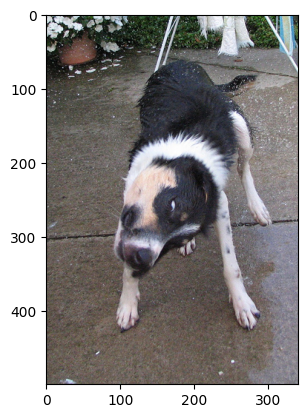

In [ ]:
plt.imshow(plt.imread(path+'/Images/'+name_of_img))

In [ ]:
genration_caption(path+'/Images/'+name_of_img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


'a dog shakes off water end of a fence end his face end end end of a yard end the street end of a body of water end of one end end of the water end end of a'

In [ ]:
beam_search_caption(path+'/Images/'+name_of_img,3)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


'<start> a dog shakes off water end'

In [ ]:
captions_dict

{'image': ['<start> caption <end>'],
 '1000268201_693b08cb0e.jpg': ['<start> a child in a pink dress is climbing up a set of stairs in an entry way  <end>',
  '<start> a girl going into a wooden building  <end>',
  '<start> a little girl climbing into a wooden playhouse  <end>',
  '<start> a little girl climbing the stairs to her playhouse  <end>',
  '<start> a little girl in a pink dress going into a wooden cabin  <end>'],
 '1001773457_577c3a7d70.jpg': ['<start> a black dog and a spotted dog are fighting <end>',
  '<start> a black dog and a tri-colored dog playing with each other on the road  <end>',
  '<start> a black dog and a white dog with brown spots are staring at each other in the street  <end>',
  '<start> two dogs of different breeds looking at each other on the road  <end>',
  '<start> two dogs on pavement moving toward each other  <end>'],
 '1002674143_1b742ab4b8.jpg': ['<start> a little girl covered in paint sits in front of a painted rainbow with her hands in a bowl  <end

In [ ]:
model_cnn.save('featur_extract.h5')

In [ ]:
model.save('model_rnn.h5')

In [ ]:
model_cnn.save('featur_extract.keras')

In [ ]:
model.save('model_rnn.keras')